In [68]:
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [96]:
import tensorflow as tf
base_dir = 'C://Users//owner//Downloads//cats2//cats//data//train'
batch_size = 32
img_size = 128

In [97]:
training_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  label_mode="int",
  validation_split=0.02,
  subset="training",
  seed=100,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 109 files belonging to 2 classes.
Using 107 files for training.


In [98]:
validation_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.15,
  subset="validation",
  seed=100,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 109 files belonging to 2 classes.
Using 16 files for validation.


In [99]:
import numpy as np
x_train = np.array([])
for x, y in training_set:
    x_train = np.concatenate([x])
len(x_train)

11

In [100]:
x_test = np.array([])
len(x_test)
for x, y in validation_set:
    x_test = np.concatenate([x])
len(x_test)

16

['sherazi', 'siami']


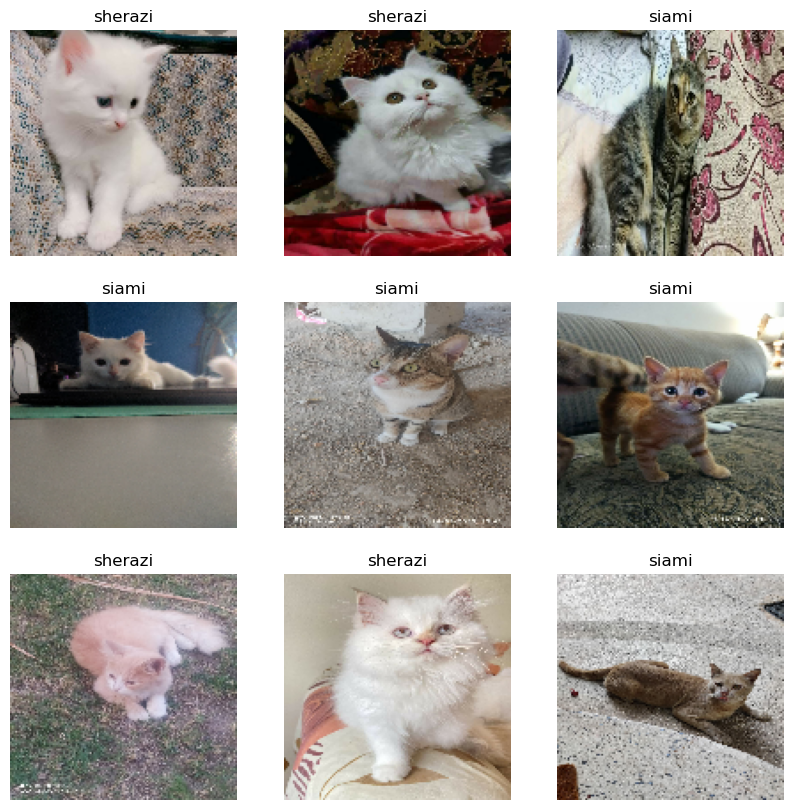

In [101]:
import matplotlib.pyplot as plt
class_names = training_set.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [102]:
# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [103]:
# Define input shape and latent dimension
latent_dim = 2
input_shape = (img_size, img_size, 3)
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
# Sampling function
@tf.function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Reparameterization trick
z = Lambda(sampling)([z_mean, z_log_var])
# Decoder network
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(16, (2, 2), activation='relu', padding='same', )(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
# Define the VAE loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
B = 1000   
vae_loss = K.mean(B * reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(kl_loss, name="kl_loss")
vae.add_metric(reconstruction_loss, name="reconstruction_loss")
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=500, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/500
1/1 [==============================] - 6s 6s/step - loss: 2610482.7500 - kl_loss: 0.0034 - reconstruction_loss: 2610.4827 - val_loss: 3237186.0000 - val_kl_loss: 161.2036 - val_reconstruction_loss: 3237.0249
Epoch 2/500
1/1 [==============================] - 2s 2s/step - loss: 2605669.5000 - kl_loss: 169.6191 - reconstruction_loss: 2605.5000 - val_loss: 3236567.0000 - val_kl_loss: 3591.4121 - val_reconstruction_loss: 3232.9756
Epoch 3/500
1/1 [==============================] - 3s 3s/step - loss: 2577183.5000 - kl_loss: 3818.6499 - reconstruction_loss: 2573.3647 - val_loss: 3445300.0000 - val_kl_loss: 28357.0703 - val_reconstruction_loss: 3416.9429
Epoch 4/500
1/1 [==============================] - 3s 3s/step - loss: 2698418.0000 - kl_loss: 30526.0332 - reconstruction_loss: 2667.8921 - val_loss: 3213243.5000 - val_kl_loss: 6224.3940 - val_reconstruction_loss: 3207.0190
Epoch 5/500
1/1 [==============================] - 3s 3s/step - loss: 2548516.2500 - kl_loss: 6717.4604 - r

Epoch 38/500
1/1 [==============================] - 2s 2s/step - loss: 1592876.1250 - kl_loss: 799.8106 - reconstruction_loss: 1592.0764 - val_loss: 4294320.0000 - val_kl_loss: 3958.8806 - val_reconstruction_loss: 4290.3608
Epoch 39/500
1/1 [==============================] - 3s 3s/step - loss: 1576034.7500 - kl_loss: 611.7466 - reconstruction_loss: 1575.4230 - val_loss: 317434656.0000 - val_kl_loss: 311410720.0000 - val_reconstruction_loss: 6023.9331
Epoch 40/500
1/1 [==============================] - 2s 2s/step - loss: 6173997.0000 - kl_loss: 2689591.2500 - reconstruction_loss: 3484.4053 - val_loss: 3114933.0000 - val_kl_loss: 979.3738 - val_reconstruction_loss: 3113.9536
Epoch 41/500
1/1 [==============================] - 3s 3s/step - loss: 1613842.8750 - kl_loss: 1370.4415 - reconstruction_loss: 1612.4724 - val_loss: 3280709.7500 - val_kl_loss: 1799.4707 - val_reconstruction_loss: 3278.9102
Epoch 42/500
1/1 [==============================] - 3s 3s/step - loss: 1743407.1250 - kl_loss

Epoch 77/500
1/1 [==============================] - 3s 3s/step - loss: nan - kl_loss: nan - reconstruction_loss: nan - val_loss: nan - val_kl_loss: nan - val_reconstruction_loss: nan
Epoch 78/500
1/1 [==============================] - 3s 3s/step - loss: nan - kl_loss: nan - reconstruction_loss: nan - val_loss: nan - val_kl_loss: nan - val_reconstruction_loss: nan
Epoch 79/500
1/1 [==============================] - 2s 2s/step - loss: nan - kl_loss: nan - reconstruction_loss: nan - val_loss: nan - val_kl_loss: nan - val_reconstruction_loss: nan
Epoch 80/500
1/1 [==============================] - 2s 2s/step - loss: nan - kl_loss: nan - reconstruction_loss: nan - val_loss: nan - val_kl_loss: nan - val_reconstruction_loss: nan
Epoch 81/500
1/1 [==============================] - 3s 3s/step - loss: nan - kl_loss: nan - reconstruction_loss: nan - val_loss: nan - val_kl_loss: nan - val_reconstruction_loss: nan
Epoch 82/500
1/1 [==============================] - 3s 3s/step - loss: nan - kl_loss:

KeyboardInterrupt: 

1/1 [==============================] - 0s 488ms/step


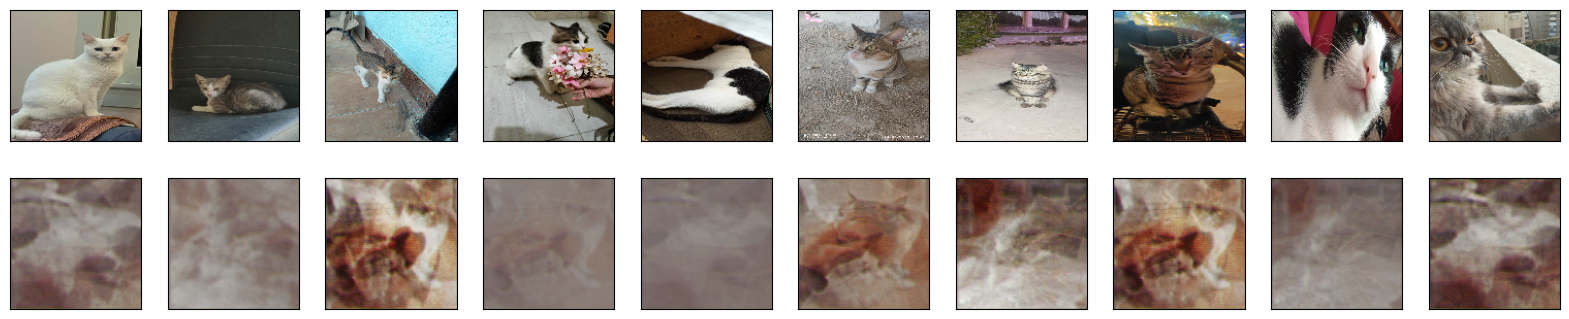

In [77]:
import matplotlib.pyplot as plt
# Convert the predictions into images
decoded_imgs = vae.predict(x_test)
# Display the original and reconstructed images
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 [==============================] - 0s 284ms/step


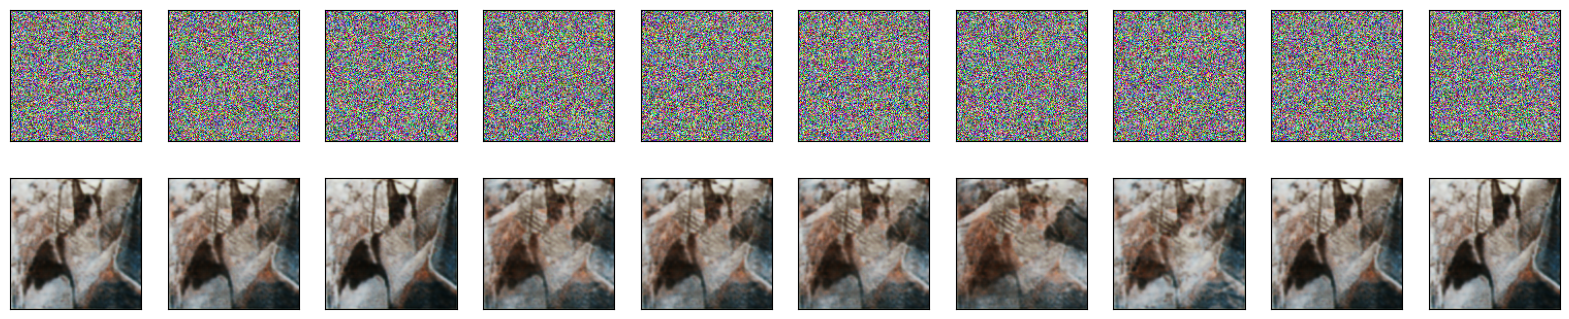

In [22]:
import matplotlib.pyplot as plt
# Convert the predictions into images
num_samples = 10
random_latent_vectors  = np.random.random((num_samples, img_size, img_size, 3))

decoded_imgs = vae.predict(random_latent_vectors)
# Display the original and reconstructed images
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(random_latent_vectors[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display the reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size,3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [106]:
# Function to load images and labels from a directory
img_size = 128  # Modify as needed

def load_data_from_directory(directory):
    images = []
    labels = []
    classes = sorted(os.listdir(directory))
    
    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (img_size, img_size))
            images.append(image)
            labels.append(class_index)  # Assign numeric label based on class index
    
    return np.array(images), np.array(labels)

# Load training data
train_directory ='C://Users//owner//Downloads//cats//data//train'
x_train, y_train = load_data_from_directory(train_directory)

# Load testing data
test_directory = 'C://Users//owner//Downloads//cats//data//test'
x_test, y_test = load_data_from_directory(test_directory)

# Normalize pixel values (optional but recommended)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

labels = set(y_train)
print(labels)
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)


{0, 1}
